# **ORATS SPY Options Chain EDA**

This notebook keeps the original EDA intent while sourcing QC diagnostics from
the pipeline artifact `qc_summary.json` instead of re-implementing manual checks
in notebook cells.

In [54]:
%load_ext autoreload
%autoreload 2

from __future__ import annotations

import json
from datetime import date
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import polars as pl
import yfinance as yf

from volatility_trading.datasets import options_chain_wide_to_long, scan_options_chain
from volatility_trading.etl.orats.qc.plotting import (
    plot_avg_volume_by_delta,
    plot_liquidity_by_dte,
    plot_smiles_by_delta,
    plot_term_structures_by_delta,
)
from volatility_trading.iv_surface.term_structure import pick_closest_dte

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Read SPY Options data

We analyze the whole chain from `2007-01-01` to `2025-12-31` and keep contracts
inside a broad tradable region.

In [3]:
TICKER = "SPY"

start = date(2007, 1, 1)
end = date(2025, 12, 31)

delta_min = 0.01
delta_max = 0.99
dte_min = 5
dte_max = 252

lf = scan_options_chain(TICKER)
lf = lf.filter(
    pl.col("trade_date").is_between(start, end),
    pl.col("call_delta").abs().is_between(delta_min, delta_max),
    pl.col("put_delta").abs().is_between(delta_min, delta_max),
    pl.col("dte").is_between(dte_min, dte_max),
)

df = lf.collect()
df_long = options_chain_wide_to_long(df).collect()

df

ticker,trade_date,expiry_date,dte,yte,underlying_price,spot_price,strike,call_volume,put_volume,call_open_interest,put_open_interest,call_bid_price,call_mid_price,call_model_price,call_ask_price,call_rel_spread,put_bid_price,put_mid_price,put_model_price,put_ask_price,put_rel_spread,smoothed_iv,call_mid_iv,put_mid_iv,call_delta,call_gamma,call_theta,call_vega,call_rho,put_delta,put_gamma,put_theta,put_vega,put_rho,risk_free_rate,dividend_yield
str,date,date,i64,f64,f64,f64,f64,i64,i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""SPY""",2007-01-03,2007-01-20,17,0.04658,141.37,141.37,132.0,0,11,1237,18579,9.6,9.7,9.74,9.8,0.020619,0.0,0.05,0.03,0.1,2.0,0.156813,0.09432,0.09613,0.983301,0.008686,-0.025484,0.012315,0.060232,-0.016699,0.008686,-0.025484,0.012315,0.060232,0.0484,0.0
"""SPY""",2007-01-03,2007-01-20,17,0.04658,141.37,141.37,133.0,0,70,1921,15443,8.7,8.75,8.77,8.8,0.011429,0.05,0.075,0.06,0.1,0.666667,0.158524,0.08551,0.16521,0.970073,0.014062,-0.029174,0.022321,0.059813,-0.029927,0.014062,-0.029174,0.022321,0.059813,0.0484,0.0
"""SPY""",2007-01-03,2007-01-20,17,0.04658,141.37,141.37,134.0,22,0,1447,22032,7.7,7.8,7.8,7.9,0.025641,0.05,0.1,0.09,0.15,1.0,0.155324,0.09083,0.15615,0.955052,0.020038,-0.032558,0.031546,0.059273,-0.044948,0.020038,-0.032558,0.031546,0.059273,0.0484,0.0
"""SPY""",2007-01-03,2007-01-20,17,0.04658,141.37,141.37,135.0,63,543,2785,35003,6.7,6.8,6.85,6.9,0.029412,0.1,0.125,0.13,0.15,0.4,0.1511,0.08124,0.14818,0.934797,0.02765,-0.036315,0.037223,0.058383,-0.065203,0.02765,-0.036315,0.037223,0.058383,0.0484,0.0
"""SPY""",2007-01-03,2007-01-20,17,0.04658,141.37,141.37,136.0,18,1741,1681,40035,5.8,5.85,5.91,5.9,0.017094,0.15,0.175,0.19,0.2,0.285714,0.145614,0.13073,0.1416,0.908534,0.037099,-0.040146,0.04943,0.0570904,-0.091466,0.037099,-0.040146,0.04943,0.0570904,0.0484,0.0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""SPY""",2025-12-05,2026-06-30,207,0.56712,685.61,685.61,850.0,0,0,202,0,0.48,0.49,0.49,0.5,0.040816,163.16,164.63,164.39,166.1,0.017858,0.126529,0.12681,0.12121,0.020504,0.000756,-0.008903,0.265688,0.07697,-0.979496,0.000756,-0.008903,0.265688,0.07697,0.036,0.013382
"""SPY""",2025-12-05,2026-06-30,207,0.56712,685.61,685.61,855.0,9,0,50,0,0.42,0.425,0.43,0.43,0.023529,168.15,169.72,169.39,171.29,0.018501,0.127016,0.12735,0.12484,0.017974,0.000673,-0.007968,0.212274,0.067501,-0.982026,0.000673,-0.007968,0.212274,0.067501,0.036,0.013382
"""SPY""",2025-12-05,2026-06-30,207,0.56712,685.61,685.61,860.0,0,0,49,0,0.37,0.375,0.37,0.38,0.026667,173.14,174.61,174.39,176.08,0.016838,0.127451,0.12803,0.1259,0.015766,0.000599,-0.007123,0.214644,0.059233,-0.984234,0.000599,-0.007123,0.214644,0.059233,0.036,0.013382


# Load QC summary artifact

The checks below are read from the quality checks summary after running `orats-api-download --config config/orats_api_download.yml`
```

In [13]:
from volatility_trading.config.paths import PROC_ORATS_OPTIONS_CHAIN

qc_summary_path = (
     PROC_ORATS_OPTIONS_CHAIN / f"underlying={TICKER}" / "qc_summary.json"
)

with qc_summary_path.open(encoding="utf-8") as f:
    qc_summary = json.load(f)

qc_by_name = {row["name"]: row for row in qc_summary}


def qc_table(names: list[str]) -> pl.DataFrame:
    """Return a compact QC table for check names that exist."""
    rows: list[dict[str, object]] = []
    for name in names:
        row = qc_by_name.get(name)
        if row is None:
            continue
        rows.append(
            {
                "name": row["name"],
                "severity": row["severity"],
                "grade": row["grade"],
                "passed": row["passed"],
                "n_rows": row.get("n_rows"),
                "n_units": row.get("n_units"),
                "n_viol": row.get("n_viol"),
                "viol_rate": row.get("viol_rate"),
            }
        )
    return pl.DataFrame(rows).sort(["severity", "name"])


def qc_top_buckets(name: str) -> pl.DataFrame:
    """Return top bucket diagnostics for one SOFT check."""
    row = qc_by_name.get(name, {})
    top_buckets = row.get("details", {}).get("top_buckets", [])
    return pl.DataFrame(top_buckets)


def qc_details(name: str) -> dict:
    """Return details payload for one QC check name."""
    return qc_by_name.get(name, {}).get("details", {})


def first_existing(*candidates: str) -> str | None:
    """Return first check name found in qc_summary."""
    for c in candidates:
        if c in qc_by_name:
            return c
    return None


def info_stats_metric(info_name: str, metric: str) -> pd.DataFrame:
    """Return one metric block from INFO core_numeric_stats."""
    stats = qc_details(info_name).get("stats", {})
    if metric not in stats:
        return pd.DataFrame()
    out = pd.DataFrame([stats[metric]])
    out.insert(0, "metric", metric)
    return out


len(qc_summary), qc_summary[0]

(68,
 {'name': 'keys_not_null',
  'severity': 'HARD',
  'grade': 'OK',
  'passed': True,
  'n_rows': 15073890,
  'n_units': None,
  'n_viol': 0,
  'viol_rate': 0.0,
  'details': {}})

# **Basic Checks**

Hard structural checks + calendar-level dataset checks from the QC summary.

In [30]:
basic_checks = qc_table(
    [
        "keys_not_null",
    ]
)
basic_checks

name,severity,grade,passed,n_rows,n_units,n_viol,viol_rate
str,str,str,bool,i64,null,i64,f64
"""keys_not_null""","""HARD""","""OK""",true,15073890,null,0,0.0


In [14]:
basic_checks = qc_table(
    [
        "keys_not_null",
        "trade_date_leq_expiry_date",
        "GLOBAL_missing_sessions_xnys",
        "GLOBAL_non_trading_dates_present_xnys",
    ]
)
basic_checks

name,severity,grade,passed,n_rows,n_units,n_viol,viol_rate
str,str,str,bool,i64,i64,i64,f64
"""keys_not_null""","""HARD""","""OK""",true,15073890,null,0,0.0
"""trade_date_leq_expiry_date""","""HARD""","""OK""",true,15073890,null,0,0.0
"""GLOBAL_missing_sessions_xnys""","""SOFT""","""OK""",true,15073890,4763,0,0.0
"""GLOBAL_non_trading_dates_prese…","""SOFT""","""MILD""",true,15073890,4764,1,0.00021


In [24]:
missing_sessions = qc_details("GLOBAL_missing_sessions_xnys").get("missing_dates", [])
non_trading = qc_details("GLOBAL_non_trading_dates_present_xnys").get("extra_dates", [])

print("Missing XNYS sessions:", len(missing_sessions))
print("Non-trading dates present:", len(non_trading))
print("Sample missing sessions:", missing_sessions[:5])
print("Sample non-trading dates:", non_trading[:5])

Missing XNYS sessions: 0
Non-trading dates present: 1
Sample missing sessions: []
Sample non-trading dates: ['2018-12-05']


After investgiation the trading date `2018-12-05` coreesponds to George W bush memorial day where the NYSE was closed but here
the options market were still opened so we can assume that we can trade on this day.

In [28]:
df.filter(pl.col("trade_date") == pl.date(2018, 12, 5))

ticker,trade_date,expiry_date,dte,yte,underlying_price,spot_price,strike,call_volume,put_volume,call_open_interest,put_open_interest,call_bid_price,call_mid_price,call_model_price,call_ask_price,call_rel_spread,put_bid_price,put_mid_price,put_model_price,put_ask_price,put_rel_spread,smoothed_iv,call_mid_iv,put_mid_iv,call_delta,call_gamma,call_theta,call_vega,call_rho,put_delta,put_gamma,put_theta,put_vega,put_rho,risk_free_rate,dividend_yield
str,date,date,i64,f64,f64,f64,f64,i64,i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""SPY""",2018-12-05,2018-12-10,5,0.0137,270.32,270.32,240.0,0,682,4,1442,30.11,30.47,30.5,30.83,0.02363,0.11,0.115,0.06,0.12,0.086957,0.459215,0.31184,0.50244,0.98811,0.0021333,-0.06793,0.009274,0.032421,-0.01189,0.0021333,-0.06793,0.009274,0.032421,0.0237,0.0
"""SPY""",2018-12-05,2018-12-10,5,0.0137,270.32,270.32,245.0,0,1340,14,1356,25.14,25.5,25.57,25.86,0.028235,0.14,0.145,0.13,0.15,0.068966,0.437442,0.27153,0.44393,0.97515,0.004205,-0.10358,0.017665,0.032616,-0.02485,0.004205,-0.10358,0.017665,0.032616,0.0237,0.0
"""SPY""",2018-12-05,2018-12-10,5,0.0137,270.32,270.32,246.0,0,41,0,0,24.15,24.505,24.6,24.86,0.028974,0.14,0.145,0.16,0.15,0.068966,0.434821,0.26258,0.42852,0.970862,0.004833,-0.114483,0.021471,0.032591,-0.029138,0.004833,-0.114483,0.021471,0.032591,0.0237,0.0
"""SPY""",2018-12-05,2018-12-10,5,0.0137,270.32,270.32,247.0,0,51,0,1,23.15,23.51,23.62,23.87,0.030625,0.15,0.155,0.18,0.16,0.064516,0.428644,0.25504,0.41758,0.96714,0.005421,-0.122714,0.025743,0.0325869,-0.03286,0.005421,-0.122714,0.025743,0.0325869,0.0237,0.0
"""SPY""",2018-12-05,2018-12-10,5,0.0137,270.32,270.32,248.0,0,66,0,0,22.16,22.52,22.65,22.88,0.031972,0.15,0.16,0.21,0.17,0.125,0.424085,0.24742,0.40435,0.962074,0.006156,-0.13381,0.025806,0.032532,-0.037926,0.006156,-0.13381,0.025806,0.032532,0.0237,0.0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""SPY""",2018-12-05,2019-06-28,205,0.56164,270.32,270.32,320.0,11,0,638,11,0.39,0.43,0.55,0.47,0.186047,49.98,50.695,53.69,51.41,0.028208,0.132639,0.12668,0.0,0.050525,0.003903,-0.007727,0.206732,0.072968,-0.949475,0.003903,-0.007727,0.206732,0.072968,0.0271,0.0
"""SPY""",2018-12-05,2019-06-28,205,0.56164,270.32,270.32,325.0,0,0,298,0,0.27,0.305,0.35,0.34,0.229508,54.97,55.685,58.69,56.4,0.02568,0.131278,0.1281,0.0,0.034592,0.002902,-0.005588,0.145047,0.050072,-0.965408,0.002902,-0.005588,0.145047,0.050072,0.0271,0.0
"""SPY""",2018-12-05,2019-06-28,205,0.56164,270.32,270.32,330.0,0,0,2510,5,0.2,0.235,0.22,0.27,0.297872,59.96,60.675,63.69,61.39,0.023568,0.130202,0.13111,0.0,0.023325,0.002105,-0.003963,0.121492,0.0338733,-0.976675,0.002105,-0.003963,0.121492,0.0338733,0.0271,0.0


As you can see contracts were traded that day.

# **Days-to-expiry check**


Here a `HARD` error will be that the current `trade_date` is larger than the exipiry
whihc is imposisble as at the latest the trade_date can match the maturity on the expiry date but beyind it is impossible.

We alos check the distributuon of the `dte` column expecting dte ranging from the tradebale filters we have applied.

In [16]:
dte_checks = qc_table(["trade_date_leq_expiry_date"])
dte_checks

name,severity,grade,passed,n_rows,n_units,n_viol,viol_rate
str,str,str,bool,i64,null,i64,f64
"""trade_date_leq_expiry_date""","""HARD""","""OK""",true,15073890,null,0,0.0


In [20]:
global_dte_stats = info_stats_metric("GLOBAL_core_numeric_stats", "dte")
print("GLOBAL DTE stats")
display(global_dte_stats)

GLOBAL DTE stats


,metric,null_rate,n_nonnull,min,max,mean,std,median,q_0.00,q_0.01,q_0.05,q_0.50,q_0.95,q_0.99,q_1.00
0,dte,0.0,15073890,1.0,252.0,67.379465,68.617457,36.0,1.0,1.0,3.0,36.0,217.0,245.0,252.0


# **Quote sanity checks**

Here we separate quote checks into 3 groups:

1. **Hard data errors** (drop-candidate rows)
   - `negative_quotes`: bid or ask below zero (impossible market quotes)
   - `crossed_market`: bid above ask (invalid quote state)
   - `bid_ask_sane`: hard guardrail summary for bid/ask consistency

2. **Suspicious but often explainable microstructure cases** (investigate first)
   - `locked_market`: bid equals ask
   - `one_sided_quotes`: no bid with positive ask
   These can happen, especially in low-liquidity wings or near close.

3. **Spread quality diagnostics**
   - `wide_spread` and `very_wide_spread`
   Not always a data error, but a trading-quality warning.
   In practice, we care whether they cluster outside the tradable ROI.

## 1) Hard quote errors (non-negotiable)

Policy:
- If these appear materially, treat affected rows as invalid candidates.
- Expected outcome in clean data: near-zero violation rates.

In [38]:
hard_quote_checks = qc_table(
    [
        "bid_ask_sane",
        "negative_quotes",
        "crossed_market",
    ]
)
hard_quote_checks

name,severity,grade,passed,n_rows,n_units,n_viol,viol_rate
str,str,str,bool,i64,null,i64,f64
"""bid_ask_sane""","""HARD""","""OK""",true,15073890,null,0,0.0
"""crossed_market""","""HARD""","""OK""",true,15073890,null,0,0.0
"""negative_quotes""","""HARD""","""OK""",true,15073890,null,0,0.0


## 2) Locked and one-sided quotes (investigate, then decide)

Policy:
- Keep as soft flags first.
- Escalate only if rates are high in ROI (10-60 DTE, 10-90 delta).

In [36]:
microstructure_quote_checks = qc_table(
    [
        "GLOBAL_locked_market_C",
        "GLOBAL_locked_market_P",
        "ROI_locked_market_C",
        "ROI_locked_market_P",
        "GLOBAL_one_sided_quotes_C",
        "GLOBAL_one_sided_quotes_P",
        "ROI_one_sided_quotes_C",
        "ROI_one_sided_quotes_P",
    ]
)
microstructure_quote_checks

name,severity,grade,passed,n_rows,n_units,n_viol,viol_rate
str,str,str,bool,i64,null,i64,f64
"""GLOBAL_locked_market_C""","""SOFT""","""OK""",true,15073890,null,29788,0.001976
"""GLOBAL_locked_market_P""","""SOFT""","""OK""",true,15073890,null,24731,0.001641
"""GLOBAL_one_sided_quotes_C""","""SOFT""","""WARN""",false,15073890,null,539559,0.035794
"""GLOBAL_one_sided_quotes_P""","""SOFT""","""MILD""",true,15073890,null,204344,0.013556
"""ROI_locked_market_C""","""SOFT""","""OK""",true,2678530,null,63,0.000024
"""ROI_locked_market_P""","""SOFT""","""OK""",true,2678530,null,103,0.000038
"""ROI_one_sided_quotes_C""","""SOFT""","""OK""",true,2678530,null,22,0.000008
"""ROI_one_sided_quotes_P""","""SOFT""","""OK""",true,2678530,null,10,0.000004


In [39]:
qc_top_buckets("GLOBAL_one_sided_quotes_P").head(10)

dte_bucket,delta_bucket,n_viol,n_rows,viol_rate_bucket,viol_share,row_share
str,str,i64,i64,f64,f64,f64
"""(0, 10]""","""(-inf, 0]""",143548,310018,0.463031,0.702482,0.041133
"""(10, 30]""","""(-inf, 0]""",14386,111212,0.129357,0.070401,0.014756
"""(0, 10]""","""(0, 0.05]""",29371,386997,0.075895,0.143733,0.051347
"""(30, 60]""","""(-inf, 0]""",592,21540,0.027484,0.002897,0.002858
"""(30, 60]""","""(0, 0.05]""",5684,251712,0.022581,0.027816,0.033397


In [40]:
qc_top_buckets("ROI_one_sided_quotes_P").head(10)

dte_bucket,delta_bucket,n_viol,n_rows,viol_rate_bucket,viol_share,row_share
str,str,i64,i64,f64,f64,f64
"""(10, 30]""","""(0.3, 0.7]""",5,275072,0.000018,0.5,0.205391
"""(10, 30]""","""(0.1, 0.3]""",2,285255,0.000007,0.2,0.212994
"""(10, 30]""","""(0.7, 0.9]""",1,149096,0.000007,0.1,0.111327
"""(30, 60]""","""(0.1, 0.3]""",1,233854,0.000004,0.1,0.174614
"""(30, 60]""","""(0.3, 0.7]""",1,242656,0.000004,0.1,0.181186


## 3) Spread diagnostics (execution quality)

Policy:
- Wide spreads are expected to be much worse in wings / short DTE.
- We focus on ROI behavior to assess strategy impact.

In [41]:
spread_quote_checks = qc_table(
    [
        "GLOBAL_wide_spread_C",
        "GLOBAL_wide_spread_P",
        "ROI_wide_spread_C",
        "ROI_wide_spread_P",
        "GLOBAL_very_wide_spread_C",
        "GLOBAL_very_wide_spread_P",
        "ROI_very_wide_spread_C",
        "ROI_very_wide_spread_P",
    ]
)
spread_quote_checks

name,severity,grade,passed,n_rows,n_units,n_viol,viol_rate
str,str,str,bool,i64,null,i64,f64
"""GLOBAL_very_wide_spread_C""","""SOFT""","""OK""",true,15073890,null,0,0.0
"""GLOBAL_very_wide_spread_P""","""SOFT""","""OK""",true,15073890,null,0,0.0
"""GLOBAL_wide_spread_C""","""SOFT""","""OK""",true,15073890,null,149886,0.009943
"""GLOBAL_wide_spread_P""","""SOFT""","""OK""",true,15073890,null,41760,0.00277
"""ROI_very_wide_spread_C""","""SOFT""","""OK""",true,2678530,null,0,0.0
"""ROI_very_wide_spread_P""","""SOFT""","""OK""",true,2678530,null,0,0.0
"""ROI_wide_spread_C""","""SOFT""","""OK""",true,2678530,null,79,0.000029
"""ROI_wide_spread_P""","""SOFT""","""OK""",true,2678530,null,234,0.000087


In [46]:
qc_top_buckets("GLOBAL_wide_spread_P").head(10)

dte_bucket,delta_bucket,n_viol,n_rows,viol_rate_bucket,viol_share,row_share
str,str,i64,i64,f64,f64,f64
"""(10, 30]""","""(-inf, 0]""",6665,111212,0.059931,0.159602,0.014756
"""(30, 60]""","""(-inf, 0]""",747,21540,0.03468,0.017888,0.002858
"""(0, 10]""","""(-inf, 0]""",9916,310018,0.031985,0.237452,0.041133
"""(30, 60]""","""(0, 0.05]""",7670,251712,0.030471,0.183669,0.033397
"""(10, 30]""","""(0, 0.05]""",9991,393513,0.025389,0.239248,0.052211


In [47]:
qc_top_buckets("ROI_wide_spread_P").head(10)

dte_bucket,delta_bucket,n_viol,n_rows,viol_rate_bucket,viol_share,row_share
str,str,i64,i64,f64,f64,f64
"""(30, 60]""","""(0.1, 0.3]""",118,233854,0.000505,0.504274,0.174614
"""(10, 30]""","""(0.1, 0.3]""",74,285255,0.000259,0.316239,0.212994
"""(10, 30]""","""(0.3, 0.7]""",21,275072,0.000076,0.089744,0.205391
"""(0, 10]""","""(0.3, 0.7]""",1,13349,0.000075,0.004274,0.009967
"""(0, 10]""","""(0.1, 0.3]""",1,14087,0.000071,0.004274,0.010518


# **Volume & Open Interest Checks**

Hard sign checks + soft mismatch diagnostics + INFO volume/OI metrics.

In [48]:
vol_oi_checks = qc_table(
    [
        "negative_vol_oi",
        "GLOBAL_zero_vol_pos_oi_C",
        "GLOBAL_zero_vol_pos_oi_P",
        "ROI_zero_vol_pos_oi_C",
        "ROI_zero_vol_pos_oi_P",
        "GLOBAL_pos_vol_zero_oi_C",
        "GLOBAL_pos_vol_zero_oi_P",
        "ROI_pos_vol_zero_oi_C",
        "ROI_pos_vol_zero_oi_P",
    ]
)
vol_oi_checks

name,severity,grade,passed,n_rows,n_units,n_viol,viol_rate
str,str,str,bool,i64,null,i64,f64
"""negative_vol_oi""","""HARD""","""OK""",true,15073890,null,0,0.0
"""GLOBAL_pos_vol_zero_oi_C""","""SOFT""","""MILD""",true,15073890,null,193694,0.01285
"""GLOBAL_pos_vol_zero_oi_P""","""SOFT""","""MILD""",true,15073890,null,242990,0.01612
"""GLOBAL_zero_vol_pos_oi_C""","""SOFT""","""MILD""",true,15073890,null,1873603,0.124295
"""GLOBAL_zero_vol_pos_oi_P""","""SOFT""","""MILD""",true,15073890,null,1260351,0.083612
"""ROI_pos_vol_zero_oi_C""","""SOFT""","""MILD""",true,2678530,null,73999,0.027627
"""ROI_pos_vol_zero_oi_P""","""SOFT""","""MILD""",true,2678530,null,80056,0.029888
"""ROI_zero_vol_pos_oi_C""","""SOFT""","""OK""",true,2678530,null,104126,0.038874
"""ROI_zero_vol_pos_oi_P""","""SOFT""","""OK""",true,2678530,null,51196,0.019113


In [49]:
pd.DataFrame(
    [
        qc_details("GLOBAL_volume_oi_metrics"),
        qc_details("ROI_volume_oi_metrics"),
    ],
    index=["GLOBAL_volume_oi_metrics", "ROI_volume_oi_metrics"],
)

,n_rows,volume_null_rate,volume_zero_rate,oi_null_rate,oi_zero_rate
GLOBAL_volume_oi_metrics,15073890,0.0,0.361542,0.0,0.182605
ROI_volume_oi_metrics,2678530,0.0,0.116327,0.0,0.115854


In [50]:
qc_top_buckets("GLOBAL_pos_vol_zero_oi_P").head(10)

dte_bucket,delta_bucket,n_viol,n_rows,viol_rate_bucket,viol_share,row_share
str,str,i64,i64,f64,f64,f64
"""(30, 60]""","""(0.3, 0.7]""",21339,242656,0.087939,0.087818,0.032196
"""(0, 10]""","""(0.95, 1]""",34470,459052,0.07509,0.141858,0.060907
"""(30, 60]""","""(0.1, 0.3]""",15410,233854,0.065896,0.063418,0.031028
"""(0, 10]""","""(0.9, 0.95]""",1982,31697,0.06253,0.008157,0.004206
"""(30, 60]""","""(0.7, 0.9]""",6867,118251,0.058071,0.02826,0.01569


# **Spot price sanity checks**

Spot consistency checks come from the QC summary; external price comparison
remains as EDA context.

In [51]:
spot_checks = qc_table(
    [
        "GLOBAL_spot_constant_per_trade_date",
        "GLOBAL_spot_equals_underlying_per_trade_date",
    ]
)
spot_checks

name,severity,grade,passed,n_rows,n_units,n_viol,viol_rate
str,str,str,bool,i64,i64,i64,f64
"""GLOBAL_spot_constant_per_trade…","""SOFT""","""OK""",true,15073890,4764,0,0.0
"""GLOBAL_spot_equals_underlying_…","""SOFT""","""OK""",true,15073890,4764,0,0.0


## ORATS SPY vs Yahoo Finance Non-adjusted Closing Price

In [52]:
spx_yf = yf.download(TICKER, start=start, end=end, auto_adjust=False)["Close"]
spx_yf = spx_yf.squeeze()
spx_yf.name = "spy_yf_close"

spx_orats = (
    df.group_by("trade_date")
    .agg(pl.col("spot_price").first().alias("spy_orats_spot"))
    .sort("trade_date")
    .to_pandas()
    .set_index("trade_date")
)

spx = pd.concat([spx_yf, spx_orats], axis=1).dropna()

diff = spx["spy_orats_spot"] - spx["spy_yf_close"]
rel_diff = diff / spx["spy_yf_close"]
corr = spx.corr().loc["spy_yf_close", "spy_orats_spot"]

print("Correlation (ORATS spot vs Yahoo close):", corr)
display(
    pd.DataFrame({"abs_diff": diff.abs(), "rel_diff": rel_diff}).describe(
        percentiles=[0.5, 0.9, 0.99]
    )
)

[*********************100%***********************]  1 of 1 completed


Correlation (ORATS spot vs Yahoo close): 0.9999912967080432


,abs_diff,rel_diff
count,4763.000000,4.763000e+03
mean,0.299487,2.111766e-05
std,0.543075,1.775399e-03
min,0.000000,-2.775000e-02
50%,0.100007,-2.776092e-09
90%,0.830001,1.340658e-03
99%,2.487591,4.921763e-03
max,7.410001,2.151342e-02


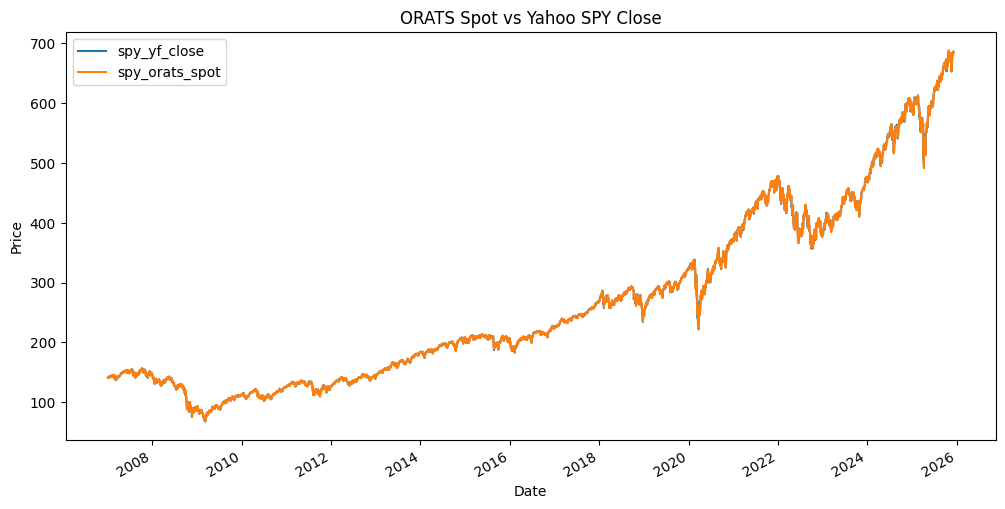

In [53]:
spx.plot(figsize=(12, 6))
plt.xlabel("Date")
plt.ylabel("Price")
plt.title("ORATS Spot vs Yahoo SPY Close")
plt.show()

# **Parity-Implied Forward Index Price Check**

Surface-level parity consistency checks are sourced from QC summary keys.

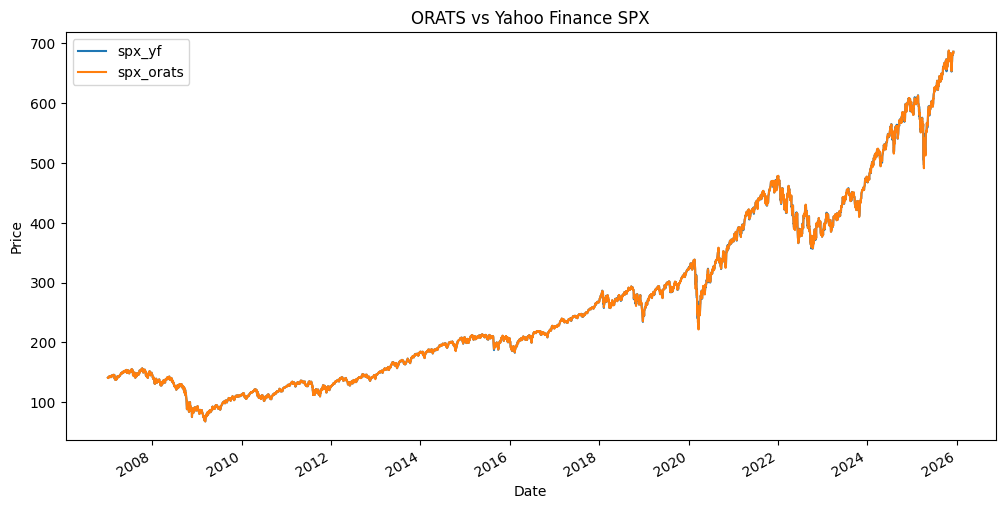

In [53]:
forward_or_spot_dataset_check = first_existing(
    "GLOBAL_forward_constant_per_trade_date_expiry",  # EU naming
    "GLOBAL_spot_equals_underlying_per_trade_date",  # AM naming
)

if forward_or_spot_dataset_check is None:
    print("No exercise-style-specific forward/spot dataset check found.")
else:
    qc_table([forward_or_spot_dataset_check])

# **Risk free rate check**

In [ ]:
rf_checks = qc_table(
    [
        "GLOBAL_unique_risk_free_rate_per_day_expiry",
    ]
)
rf_checks

In [ ]:
pd.DataFrame(
    [
        qc_details("GLOBAL_risk_free_rate_metrics"),
        qc_details("ROI_risk_free_rate_metrics"),
    ],
    index=["GLOBAL_risk_free_rate_metrics", "ROI_risk_free_rate_metrics"],
)

# **Implied Volatility Quality Checks**

In [60]:
iv_checks = qc_table(
    [
        "iv_non_negative",
        "GLOBAL_high_iv",
        "GLOBAL_very_high_iv",
    ]
)
iv_checks

statistic,smoothed_iv
str,f64
"""count""",5.167888e6
"""null_count""",0.0
"""mean""",0.210896
"""std""",0.094263
"""min""",0.01
"""25%""",0.143111
"""50%""",0.194009
"""75%""",0.256903
"""max""",1.431536


In [ ]:
display(info_stats_metric("GLOBAL_core_numeric_stats", "smoothed_iv"))
display(info_stats_metric("ROI_core_numeric_stats", "smoothed_iv"))

n_negative,n_above_300pct
u32,u32
0,0


## Smile shape for 10, 30 and 60 DTE

In [62]:
picked_dates = [
    date(2008, 10, 10),  # GFC
    date(2010, 12, 2),
    date(2013, 6, 13),
    date(2015, 8, 24),  # vol event
    date(2018, 2, 5),  # volmageddon
    date(2018, 9, 12),
    date(2020, 3, 16),  # covid crash
    date(2022, 6, 16),  # high vol / rates
    date(2025, 3, 3),
]

event_labels = {
    date(2008, 10, 10): "GFC stress",
    date(2015, 8, 24): "China / flash crash",
    date(2018, 2, 5): "Volmageddon",
    date(2020, 3, 16): "Covid crash",
    date(2022, 6, 16): "Rates/Inflation stress",
}

plot_smiles_by_delta(df, picked_dates=picked_dates, event_labels=event_labels)

## IV Term-Structure Shapes

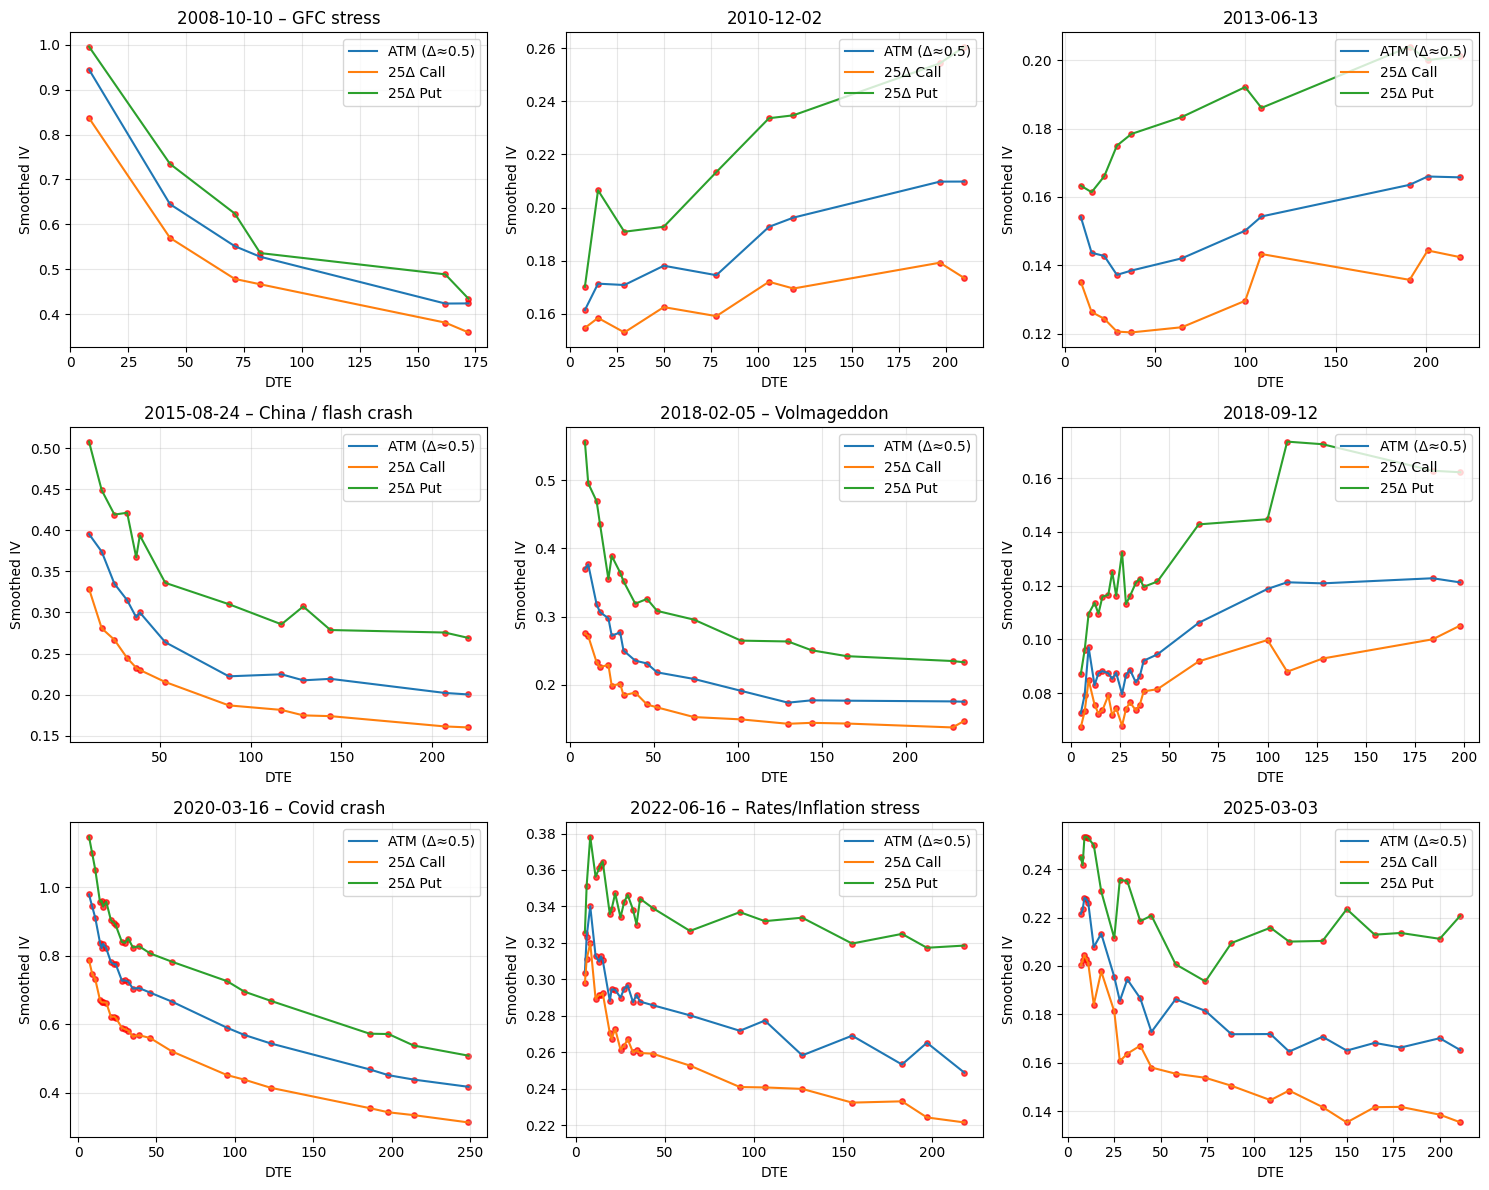

In [64]:
plot_term_structures_by_delta(df, picked_dates=picked_dates, event_labels=event_labels)

# **Greeks Sanity Checks**

Use hard + soft QC results and keep a strike slice plot for intuition.

In [ ]:
greeks_checks = qc_table(
    [
        "gamma_non_negative",
        "vega_non_negative",
        "GLOBAL_delta_bounds_sane_C",
        "GLOBAL_delta_bounds_sane_P",
        "ROI_delta_bounds_sane_C",
        "ROI_delta_bounds_sane_P",
        "GLOBAL_theta_positive_C",
        "GLOBAL_theta_positive_P",
        "ROI_theta_positive_C",
        "ROI_theta_positive_P",
    ]
)
greeks_checks

In [ ]:
qc_top_buckets("GLOBAL_theta_positive_P").head(10)

## Greeks vs Strike

In [68]:
day = date(2024, 12, 16)
dte_target = 30

sub = df_long.filter(pl.col("trade_date") == day)
dtes_for_day = sub.select(pl.col("dte").unique()).sort("dte").to_series().to_list()

dte_true = pick_closest_dte(dtes_for_day, dte_target, max_tol=10)
if dte_true is None:
    raise ValueError(f"No DTE within 10 days of target={dte_target} on {day}")

sub = sub.filter(pl.col("dte") == dte_true).sort("strike")
S = sub.select("underlying_price").to_series().item(0)
calls = sub.filter(pl.col("option_type") == "C")
puts = sub.filter(pl.col("option_type") == "P")

fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=False)
ax_d, ax_g = axes[0]
ax_v, ax_t = axes[1]

plots = [
    ("delta", ax_d, "Delta", "Delta vs strike"),
    ("gamma", ax_g, "Gamma", "Gamma vs strike"),
    ("vega", ax_v, "Vega", "Vega vs strike"),
    ("theta", ax_t, "Theta", "Theta vs strike"),
]

for col, ax, ylabel, title in plots:
    ax.plot(calls["strike"], calls[col], label=f"Call {col}", marker="o")
    ax.plot(puts["strike"], puts[col], label=f"Put {col}", marker="o")
    ax.axvline(S, linestyle="--", linewidth=0.8, label="Spot S")
    ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.grid(True, alpha=0.3)
    ax.legend()

ax_v.set_xlabel("Strike")
ax_t.set_xlabel("Strike")
fig.suptitle(f"Greeks vs strike - {day}, DTE={dte_true}, S={S:.2f}")
fig.tight_layout()
plt.show()

# **Model-driven / arbitrage checks**

Liquidity context remains EDA-driven.

## Volume for Calls/Puts by $\Delta$ Moneyness

/Users/anthony/VSCode/python_project/volatility_trading/src/volatility_trading/etl/orats/qc/orats_qc_plotting.py:229: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = vol_by_delta.pivot_table(


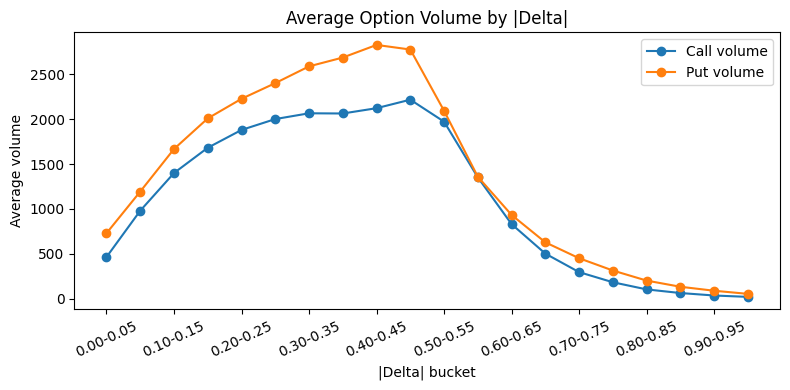

In [92]:
plot_avg_volume_by_delta(df_long)

## Volume/Open Interest by DTE

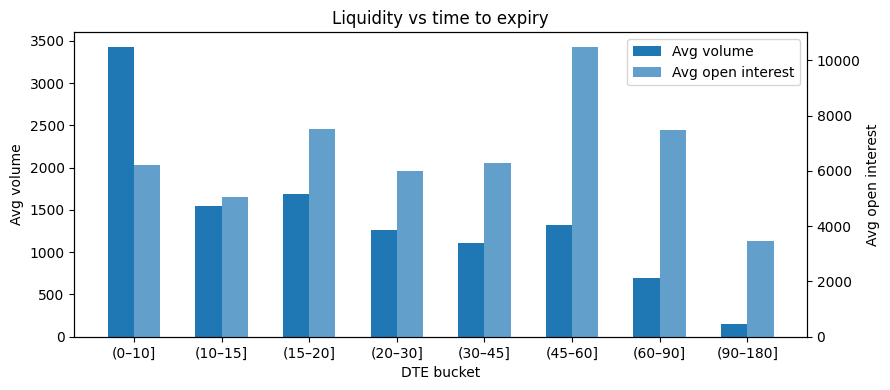

In [93]:
plot_liquidity_by_dte(df_long)

# **Put-Call Parity checks**

Pull parity diagnostics from summary keys (AM/EU aware).

In [ ]:
pcp_checks = qc_table(
    [
        "GLOBAL_pcp_mid_eu_forward",
        "ROI_pcp_mid_eu_forward",
        "GLOBAL_pcp_bounds_mid_am",
        "ROI_pcp_bounds_mid_am",
    ]
)
pcp_checks

In [ ]:
pcp_global_name = first_existing("GLOBAL_pcp_mid_eu_forward", "GLOBAL_pcp_bounds_mid_am")
if pcp_global_name is not None:
    qc_top_buckets(pcp_global_name).head(10)

# **Arbitrage bounds for call & put prices**

Price-bound diagnostics from summary keys.

In [94]:
bounds_checks = qc_table(
    [
        "GLOBAL_price_bounds_mid_eu_forward_C",
        "GLOBAL_price_bounds_mid_eu_forward_P",
        "ROI_price_bounds_mid_eu_forward_C",
        "ROI_price_bounds_mid_eu_forward_P",
        "GLOBAL_price_bounds_mid_am_C",
        "GLOBAL_price_bounds_mid_am_P",
        "ROI_price_bounds_mid_am_C",
        "ROI_price_bounds_mid_am_P",
    ]
)
bounds_checks

In [ ]:
bounds_global_put = first_existing(
    "GLOBAL_price_bounds_mid_eu_forward_P",
    "GLOBAL_price_bounds_mid_am_P",
)
if bounds_global_put is not None:
    qc_top_buckets(bounds_global_put).head(10)

## Strike & maturity monotonicity checks

Use SOFT monotonicity checks from qc summary.

In [ ]:
monotonicity_checks = qc_table(
    [
        "GLOBAL_strike_monotonicity_C",
        "GLOBAL_strike_monotonicity_P",
        "ROI_strike_monotonicity_C",
        "ROI_strike_monotonicity_P",
        "GLOBAL_maturity_monotonicity_C",
        "GLOBAL_maturity_monotonicity_P",
        "ROI_maturity_monotonicity_C",
        "ROI_maturity_monotonicity_P",
    ]
)
monotonicity_checks

statistic,parity_diff
str,f64
"""count""",5.167888e6
"""null_count""",0.0
"""mean""",0.248105
"""std""",1.444381
"""min""",-96.153626
"""25%""",-0.017047
"""50%""",0.179784
"""75%""",0.850402
"""max""",21.223839


In [99]:
qc_top_buckets("GLOBAL_strike_monotonicity_P").head(10)

ticker,trade_date,expiry_date,dte,yte,underlying_price,spot_price,strike,call_volume,put_volume,call_open_interest,put_open_interest,call_bid_price,call_mid_price,call_model_price,call_ask_price,call_rel_spread,put_bid_price,put_mid_price,put_model_price,put_ask_price,put_rel_spread,smoothed_iv,call_mid_iv,put_mid_iv,call_delta,call_gamma,call_theta,call_vega,call_rho,put_delta,put_gamma,put_theta,put_vega,put_rho,risk_free_rate,dividend_yield,disc_q,disc_r,lhs,rhs,parity_diff
str,date,date,i64,f64,f64,f64,f64,i64,i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""SPY""",2007-01-03,2007-02-17,45,0.12329,141.37,141.37,147.0,561,366,5249,761,0.35,0.375,0.37,0.4,0.133333,5.5,5.6,5.63,5.7,0.035714,0.091463,0.09163,0.05451,0.157908,0.05329,-0.015348,0.115937,0.027067,-0.842092,0.05329,-0.03556,0.115937,-0.153044,0.0505,0.0,1.0,0.993793,-5.225,-4.7176,-0.5074
"""SPY""",2007-01-04,2007-02-17,44,0.12055,141.67,141.67,147.0,837,162,5773,666,0.3,0.35,0.37,0.4,0.285714,5.2,5.3,5.33,5.4,0.037736,0.089038,0.08699,0.05253,0.162653,0.056342,-0.01546,0.128629,0.027333,-0.837347,0.056342,-0.035635,0.128629,-0.148802,0.0504,0.0,1.0,0.993943,-4.95,-4.439577,-0.510423
"""SPY""",2007-01-04,2007-02-17,44,0.12055,141.67,141.67,148.0,42,40,1943,27,0.15,0.175,0.21,0.2,0.285714,6.2,6.3,6.33,6.4,0.031746,0.085452,0.08167,0.05866,0.103968,0.043046,-0.010644,0.093091,0.0175087,-0.896032,0.043046,-0.030956,0.093091,-0.159825,0.0504,0.0,1.0,0.993943,-6.125,-5.43352,-0.69148
"""SPY""",2007-01-08,2007-02-17,40,0.10959,141.19,141.19,147.0,117,0,6600,266,0.2,0.225,0.19,0.25,0.222222,5.7,5.8,5.81,5.9,0.034483,0.082465,0.08583,0.05944,0.105832,0.047555,-0.011045,0.090143,0.016165,-0.894168,0.047555,-0.031391,0.090143,-0.144038,0.0508,0.0,1.0,0.994448,-5.575,-4.9939,-0.5811
"""SPY""",2007-01-09,2007-02-17,39,0.10685,141.07,141.07,147.0,66,478,6654,251,0.15,0.2,0.2,0.25,0.5,5.9,6.0,5.93,6.1,0.033333,0.087144,0.08643,0.06427,0.106086,0.045674,-0.011484,0.084944,0.015776,-0.893914,0.045674,-0.031833,0.084944,-0.140443,0.0508,0.0,1.0,0.994587,-5.8,-5.134249,-0.665751
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""SPY""",2025-12-05,2026-01-30,56,0.15342,685.61,685.61,721.0,2,0,106,0,2.6,2.61,2.6,2.62,0.007663,35.41,36.865,35.88,38.32,0.078937,0.105609,0.11822,0.11748,0.130857,0.007509,-0.058933,0.552247,0.134849,-0.866601,0.007509,-0.100722,0.552247,-0.96503,0.0371,0.016588,0.997458,0.994324,-34.255,-33.040471,-1.214529
"""SPY""",2025-12-05,2026-01-30,56,0.15342,685.61,685.61,722.0,1,0,107,2,2.43,2.445,2.45,2.46,0.01227,36.29,37.755,36.79,39.22,0.077606,0.10525,0.11786,0.07404,0.123026,0.007214,-0.056141,0.554172,0.126823,-0.874432,0.007214,-0.098031,0.554172,-0.974583,0.0371,0.016588,0.997458,0.994324,-35.31,-34.034796,-1.275204
"""SPY""",2025-12-05,2026-01-30,56,0.15342,685.61,685.61,723.0,2,0,258,0,2.28,2.295,2.29,2.31,0.013072,37.15,38.635,37.71,40.12,0.076873,0.104947,0.11764,0.0745,0.115286,0.006917,-0.053424,0.556062,0.118887,-0.882172,0.006917,-0.095415,0.556062,-0.984044,0.0371,0.016588,0.997458,0.994324,-36.34,-35.02912,-1.31088


In [100]:
qc_top_buckets("GLOBAL_maturity_monotonicity_P").head(10)

ticker,trade_date,expiry_date,dte,yte,underlying_price,spot_price,strike,call_volume,put_volume,call_open_interest,put_open_interest,call_bid_price,call_mid_price,call_model_price,call_ask_price,call_rel_spread,put_bid_price,put_mid_price,put_model_price,put_ask_price,put_rel_spread,smoothed_iv,call_mid_iv,put_mid_iv,call_delta,call_gamma,call_theta,call_vega,call_rho,put_delta,put_gamma,put_theta,put_vega,put_rho,risk_free_rate,dividend_yield,disc_q,disc_r,lhs,rhs,parity_diff,total_spread
str,date,date,i64,f64,f64,f64,f64,i64,i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""SPY""",2007-01-03,2007-02-17,45,0.12329,141.37,141.37,147.0,561,366,5249,761,0.35,0.375,0.37,0.4,0.133333,5.5,5.6,5.63,5.7,0.035714,0.091463,0.09163,0.05451,0.157908,0.05329,-0.015348,0.115937,0.027067,-0.842092,0.05329,-0.03556,0.115937,-0.153044,0.0505,0.0,1.0,0.993793,-5.225,-4.7176,-0.5074,0.25
"""SPY""",2007-01-04,2007-02-17,44,0.12055,141.67,141.67,147.0,837,162,5773,666,0.3,0.35,0.37,0.4,0.285714,5.2,5.3,5.33,5.4,0.037736,0.089038,0.08699,0.05253,0.162653,0.056342,-0.01546,0.128629,0.027333,-0.837347,0.056342,-0.035635,0.128629,-0.148802,0.0504,0.0,1.0,0.993943,-4.95,-4.439577,-0.510423,0.3
"""SPY""",2007-01-04,2007-02-17,44,0.12055,141.67,141.67,148.0,42,40,1943,27,0.15,0.175,0.21,0.2,0.285714,6.2,6.3,6.33,6.4,0.031746,0.085452,0.08167,0.05866,0.103968,0.043046,-0.010644,0.093091,0.0175087,-0.896032,0.043046,-0.030956,0.093091,-0.159825,0.0504,0.0,1.0,0.993943,-6.125,-5.43352,-0.69148,0.25
"""SPY""",2007-01-08,2007-02-17,40,0.10959,141.19,141.19,147.0,117,0,6600,266,0.2,0.225,0.19,0.25,0.222222,5.7,5.8,5.81,5.9,0.034483,0.082465,0.08583,0.05944,0.105832,0.047555,-0.011045,0.090143,0.016165,-0.894168,0.047555,-0.031391,0.090143,-0.144038,0.0508,0.0,1.0,0.994448,-5.575,-4.9939,-0.5811,0.25
"""SPY""",2007-01-09,2007-02-17,39,0.10685,141.07,141.07,147.0,66,478,6654,251,0.15,0.2,0.2,0.25,0.5,5.9,6.0,5.93,6.1,0.033333,0.087144,0.08643,0.06427,0.106086,0.045674,-0.011484,0.084944,0.015776,-0.893914,0.045674,-0.031833,0.084944,-0.140443,0.0508,0.0,1.0,0.994587,-5.8,-5.134249,-0.665751,0.3
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""SPY""",2025-12-05,2026-01-30,56,0.15342,685.61,685.61,713.0,148,0,352,3,4.27,4.28,4.28,4.29,0.004673,29.84,30.09,30.1,30.34,0.016617,0.110564,0.1208,0.12396,0.209488,0.009719,-0.084867,0.744367,0.215084,-0.78797,0.009719,-0.125848,0.744367,-0.872592,0.0371,0.016588,0.997458,0.994324,-25.81,-25.085877,-0.724123,0.52
"""SPY""",2025-12-05,2026-01-30,56,0.15342,685.61,685.61,714.0,1,0,171,2,4.02,4.035,4.04,4.05,0.007435,30.65,30.91,30.92,31.17,0.016823,0.10978,0.12042,0.12409,0.198599,0.009473,-0.081394,0.747224,0.204008,-0.798859,0.009473,-0.122475,0.747224,-0.885193,0.0371,0.016588,0.997458,0.994324,-26.875,-26.080201,-0.794799,0.55
"""SPY""",2025-12-05,2026-01-30,56,0.15342,685.61,685.61,715.0,284,30,4694,13,3.78,3.795,3.79,3.81,0.007905,31.53,31.755,31.74,31.98,0.014171,0.109029,0.12011,0.12447,0.187628,0.009217,-0.077959,0.750083,0.1928418,-0.80983,0.009217,-0.119142,0.750083,-0.897885,0.0371,0.016588,0.997458,0.994324,-27.96,-27.074526,-0.885474,0.48
